In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from composition_stats import ilr, ilr_inv, closure
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
raw_data = pd.read_excel("Datos_Market_copy.xlsx")

data = raw_data.copy()
data.set_index("date", inplace=True)

# Unify the brand names to 4 categories (brand-15, brand-14, brand-35, other)
for i in data["brand"]:
    if i != "brand-15" and i != "brand-14" and i != "brand-35":
        # change the name
        # test_data["brand"].replace(i, "other", inplace=True)
        data["brand"].replace({i: "other"}, inplace=True)


sales = ["volume.sales", "value.sales", "unit.sales"]

pack_size350 = data["pack.size"].isin(["0 - 350 GR"])
pack_size500 = data["pack.size"].isin(["351 - 500 GR"])
pack_size1000 = data["pack.size"].isin(["701 - 1000 GR"])
pack_size = data["pack.size"].isin(["0 - 350 GR", "351 - 500 GR"])

brand35 = data["brand"].isin(["brand-35"])
brand15 = data["brand"].isin(["brand-15"])
brand14 = data["brand"].isin(["brand-14"])
brandOther = data["brand"].isin(["other"])

variantF = data["variant"].isin(["flavoured"])
variantL = data["variant"].isin(["light"])
variantS = data["variant"].isin(["standard"])
variantV = data["variant"].isin(["vegan"])

supermarketA = data["supermarket"].isin(["supermarket-A"])
supermarketB = data["supermarket"].isin(["supermarket-B"])
supermarketC = data["supermarket"].isin(["supermarket-C"])
supermarketD = data["supermarket"].isin(["supermarket-D"])

/var/folders/r4/_d0jbzx9629841ty8b0gfn040000gn/T/ipykernel_9643/759143010.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["brand"].replace({i: "other"}, inplace=True)


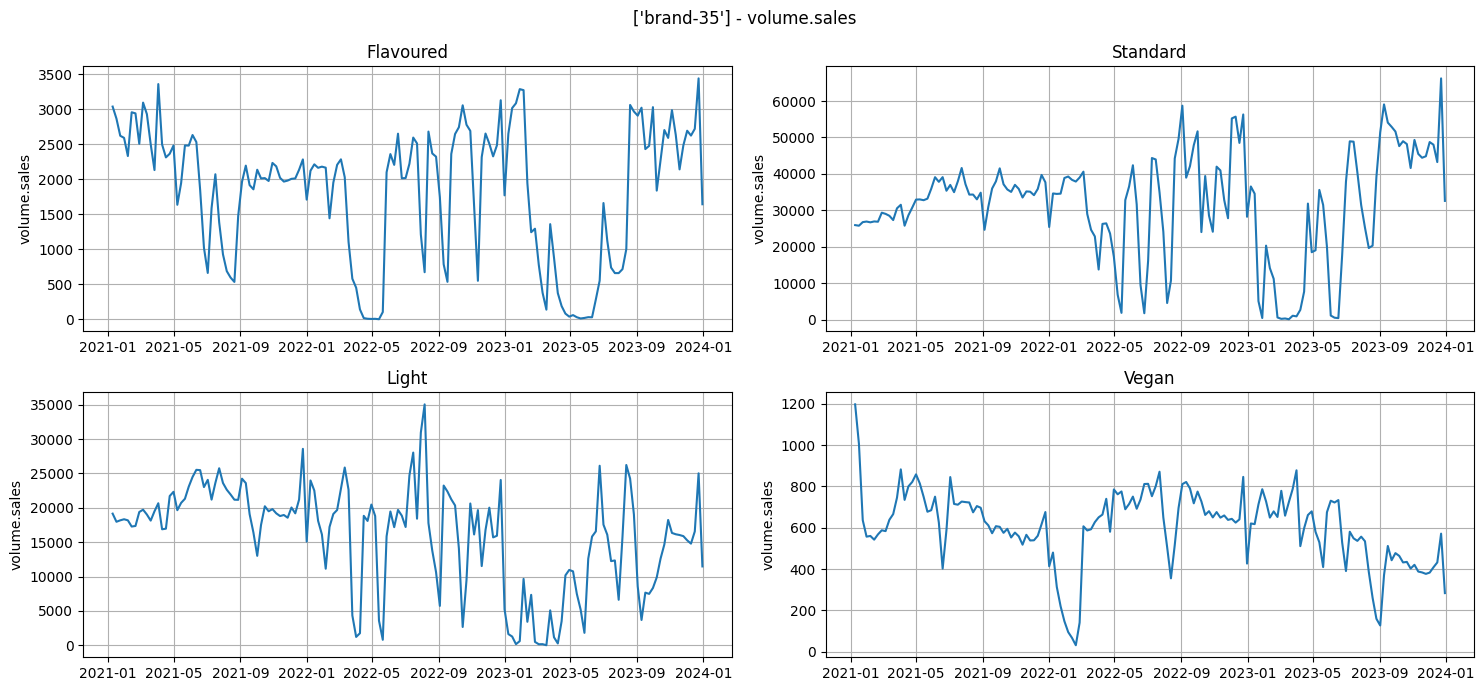

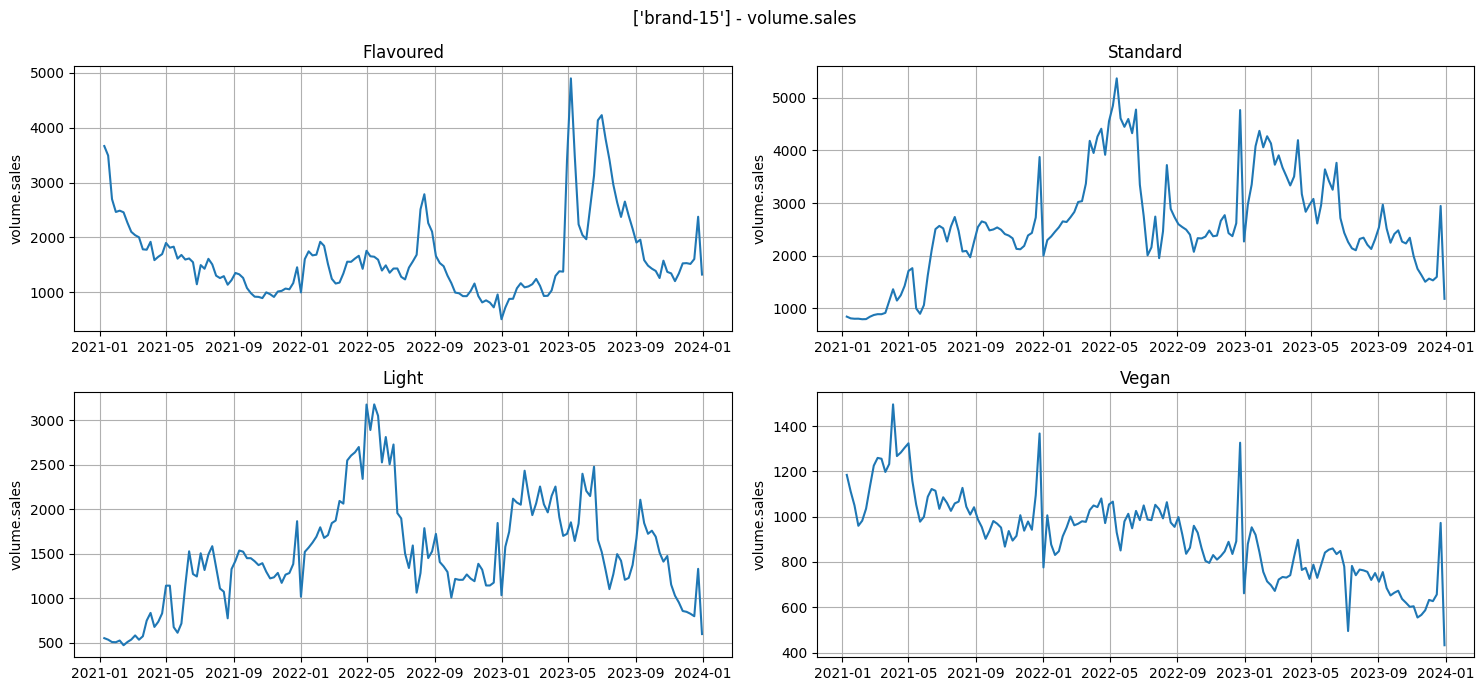

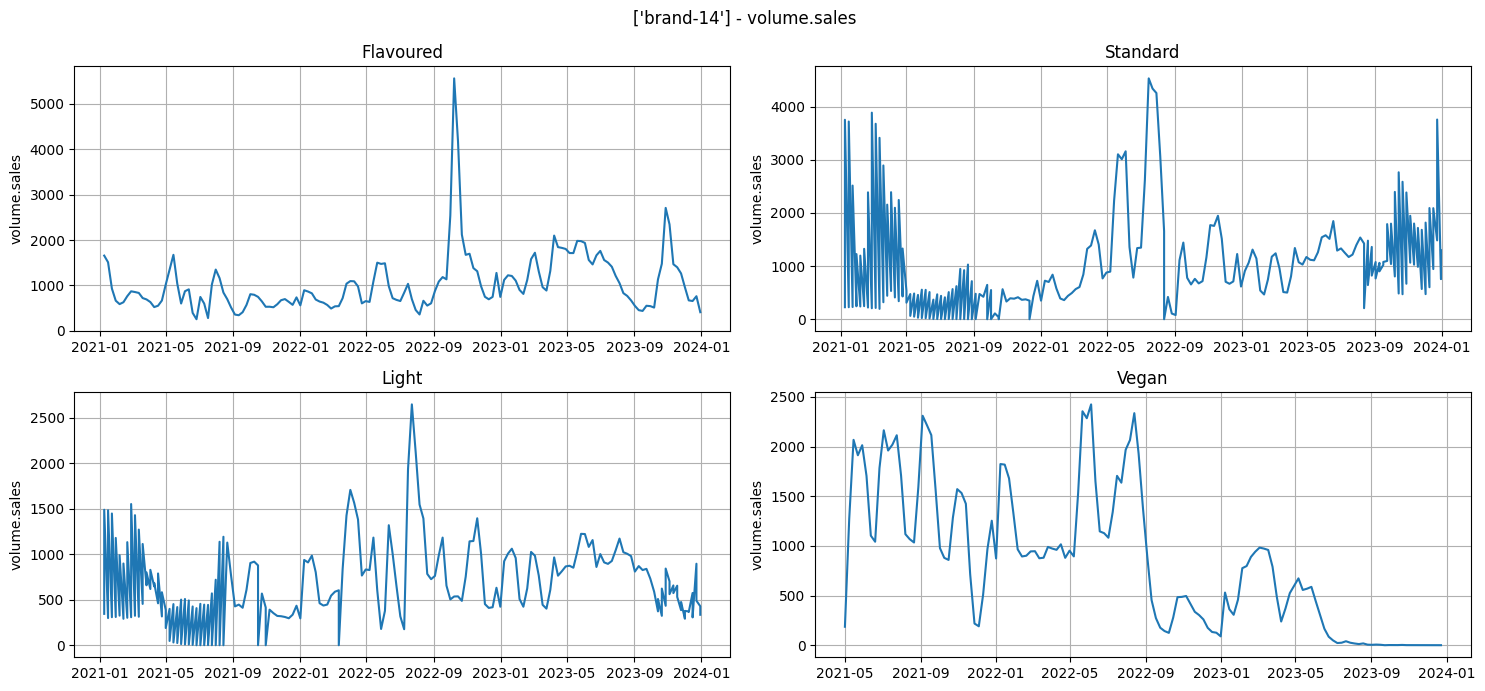

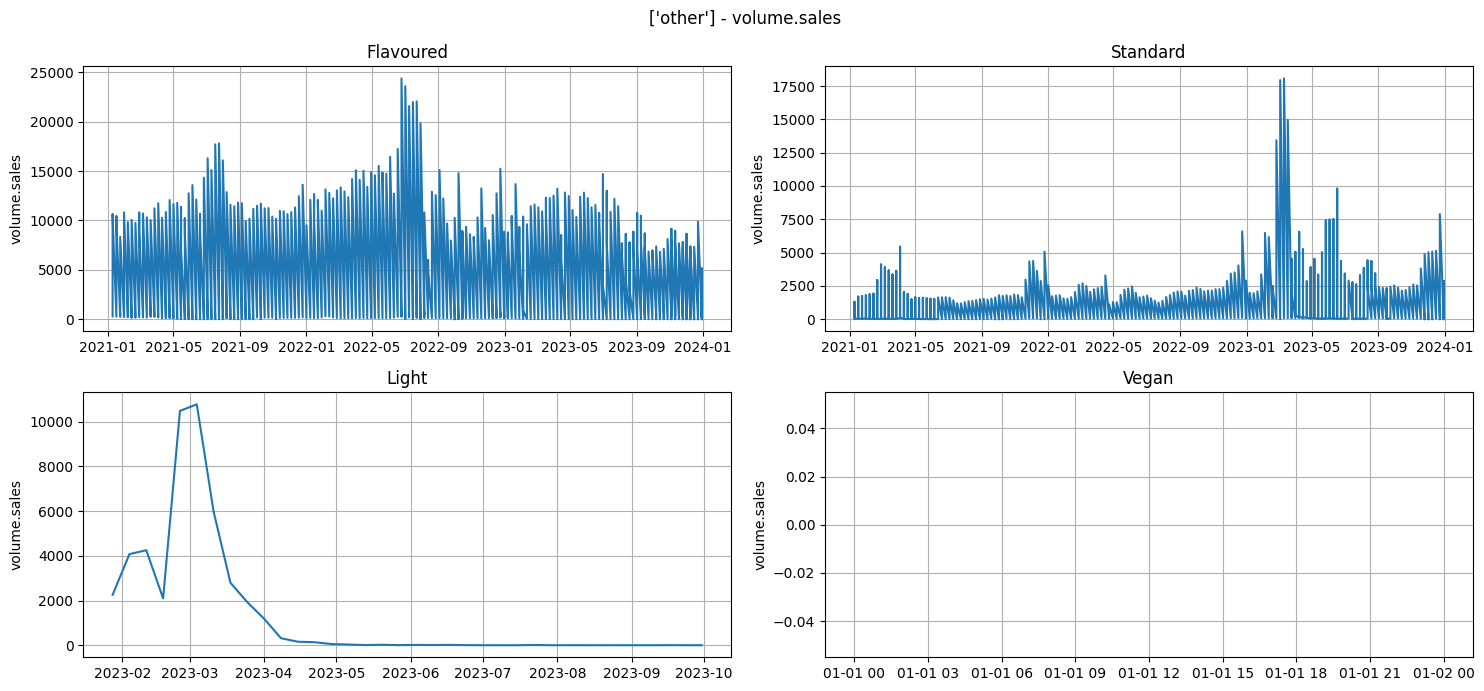

In [54]:
def plot_data(brand, supermarket, pack_size, sales):
    fig, ax = plt.subplots(2, 2, figsize=(15, 7))

    ax[0, 0].plot(data[(brand) & (variantF) & (supermarket) & (pack_size)][sales])
    ax[0, 0].set_title("Flavoured")
    ax[0, 0].set_ylabel(sales)
    ax[0, 0].grid(True)

    ax[0, 1].plot(data[(brand) & (variantS) & (supermarket) & (pack_size)][sales])
    ax[0, 1].set_title("Standard")
    ax[0, 1].set_ylabel(sales)
    ax[0, 1].grid(True)

    ax[1, 0].plot(data[(brand) & (variantL) & (supermarket) & (pack_size)][sales])
    ax[1, 0].set_title("Light")
    ax[1, 0].set_ylabel(sales)
    ax[1, 0].grid(True)

    ax[1, 1].plot(data[(brand) & (variantV) & (supermarket) & (pack_size)][sales])
    ax[1, 1].set_title("Vegan")
    ax[1, 1].set_ylabel(sales)
    ax[1, 1].grid(True)

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


# %matplotlib inline
plot_data(brand35, pack_size, supermarketA, "volume.sales")
plot_data(brand15, pack_size350, supermarketA, "volume.sales")
plot_data(brand14, pack_size, supermarketA, "volume.sales")
plot_data(brandOther, pack_size, supermarketA, "volume.sales")

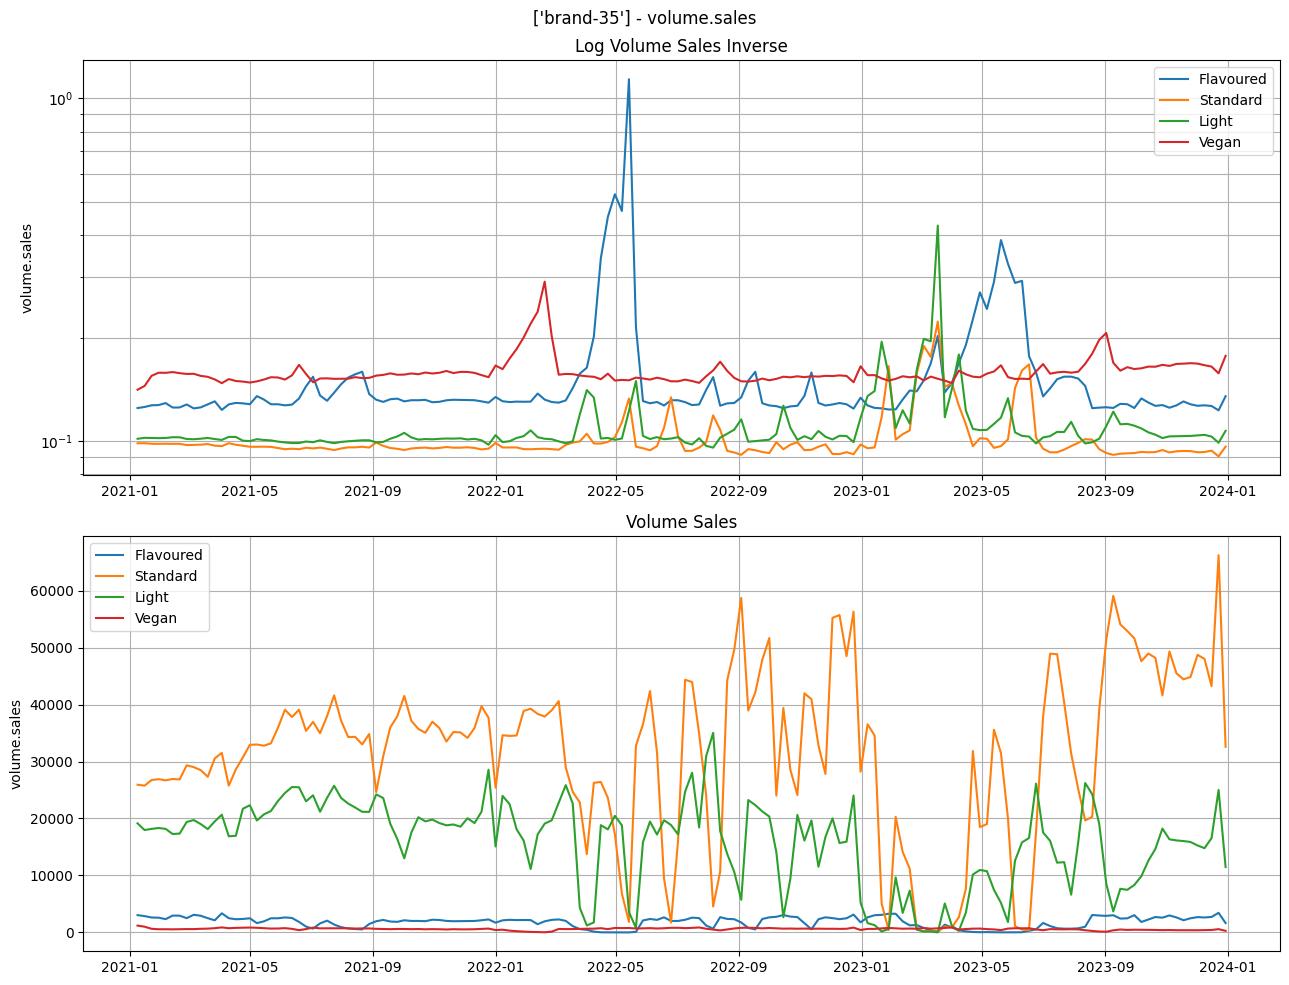

In [57]:
# haz logaritmo de las ventas
def log_graphs(brand, sales):
    fig, ax = plt.subplots(2, 1, figsize=(13, 10))

    ax[0].plot(
        1 / np.log(data[(brand) & (variantF) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantS) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantL) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantV) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].set_title("Log Volume Sales Inverse")
    ax[0].set_ylabel("volume.sales")
    ax[0].set_yscale("log")
    ax[0].grid(True, which="both")
    ax[0].legend(["Flavoured", "Standard", "Light", "Vegan"])

    ax[1].plot(
        data[(brand) & (variantF) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantS) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantL) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantV) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].set_title("Volume Sales")
    ax[1].set_ylabel("volume.sales")
    ax[1].grid(
        True,
    )
    ax[1].legend(["Flavoured", "Standard", "Light", "Vegan"])

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


log_graphs(brand35, "volume.sales")
# log_graphs(brand15, "volume.sales")
# log_graphs(brand14, "volume.sales")
# log_graphs(brandOther, "volume.sales")

In [58]:
import statsmodels.api as sm


def modelization(data_filtered):

    # Create dummy variables for the supermarket column
    data_dummies = pd.get_dummies(
        data_filtered, columns=["supermarket", "variant"], drop_first=True
    )

    for col in [
        "supermarket_supermarket-B",
        "supermarket_supermarket-C",
        "supermarket_supermarket-D",
        "variant_light",
        "variant_standard",
        "variant_vegan",
        # "pack.size_351 - 500 GR",
        # "pack.size_701 - 1000 GR",
        # "pack.size_501 - 700 GR",
    ]:
        data_dummies[col] = data_dummies[col].astype(int)

    X = data_dummies[
        [
            "unit.sales",
            "supermarket_supermarket-B",
            "supermarket_supermarket-C",
            "supermarket_supermarket-D",
            "variant_light",
            "variant_standard",
            "variant_vegan",
            # "pack.size_351 - 500 GR",
            # "pack.size_701 - 1000 GR",
            # "pack.size_501 - 700 GR",
        ]
    ]

    X = sm.add_constant(X)

    y = data_dummies["volume.sales"]

    # Adjust the model
    model = sm.OLS(y, X).fit()

    model_summary = model.summary()

    return data_dummies, model


data_dummies, model = modelization(
    data[(brand35) & (pack_size350)]
)  # made the model for brand-35

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           volume.sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2101.
Date:                Sat, 21 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:29:00   Log-Likelihood:                -10304.
No. Observations:                1328   AIC:                         2.062e+04
Df Residuals:                    1320   BIC:                         2.067e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       623.8900     47.372     13.170      0.000     530.958     716.822
unit.sales                    0.1664      0.003     55.435      0.000       0.161       0.172
supermarket_supermarket-B  -444.5452     45.134     -9.849      0.000    -533.088    -356.002
supermarket_supermarket-C   767.5154     57.331     13.388      0.000     655.047     879.984
supermarket_supermarket-D   708.7581     54.151     13.089      0.000     602.527     814.989
variant_light             -1391.3114    211.386     -6.582      0.000   -1806.001    -976.622
variant_standard           -887.0683     62.371    -14.223      0.000   -1009.425    -764.712
variant_vegan              -365.0266     48.122     -7.585      0.000    -459.430    -270.623
==============================================================================
Omnibus:                      500.847   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2966.061
Skew:                          -1.638   Prob(JB):                         0.00
Kurtosis:                       9.547   Cond. No.                     1.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 1000x300 with 0 Axes>

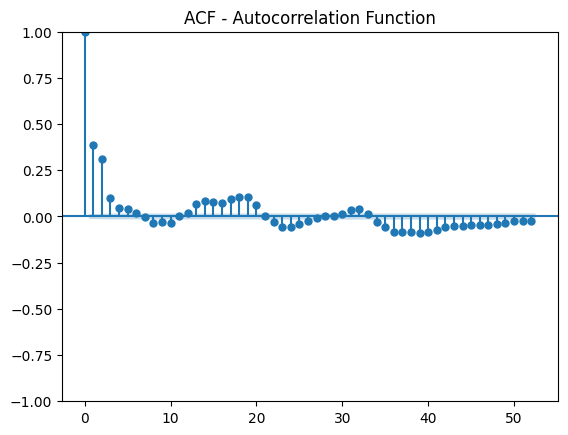

<Figure size 1000x300 with 0 Axes>

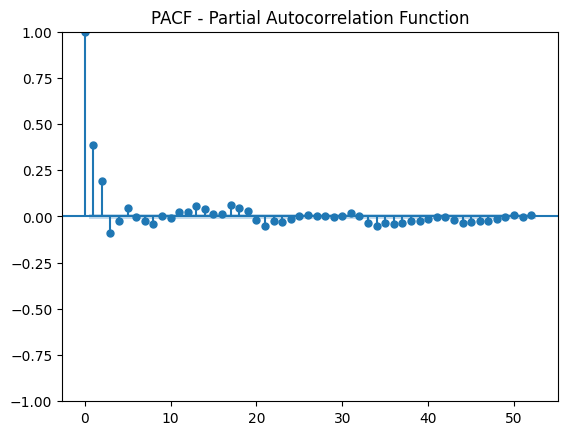

<Figure size 1000x300 with 0 Axes>

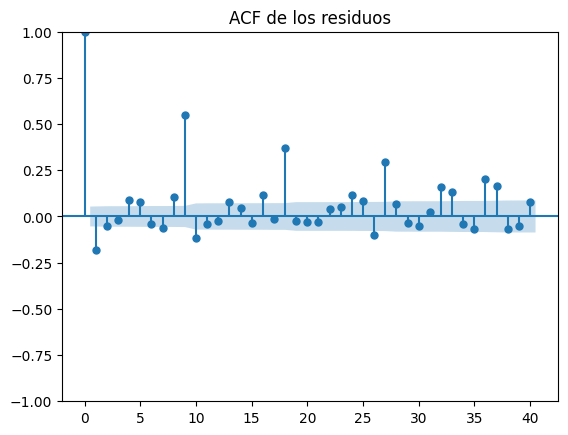

<Figure size 1000x300 with 0 Axes>

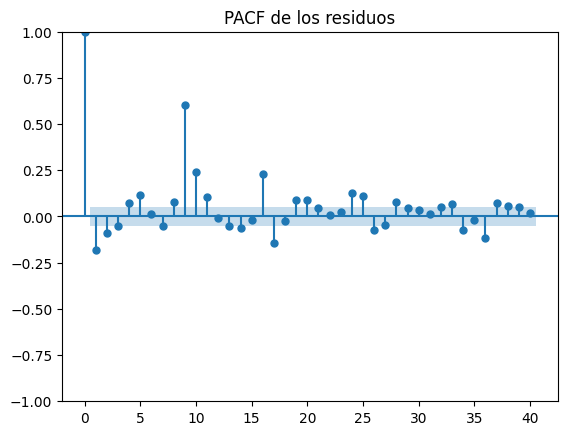

In [35]:
# %matplotlib widget
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plt.figure(figsize=(10, 3))
plot_acf(data["volume.sales"], lags=52)  # Ajusta los 'lags' según tu preferencia
plt.title("ACF - Autocorrelation Function")
plt.show()

# PACF
plt.figure(figsize=(10, 3))
plot_pacf(data["volume.sales"], lags=52)  # Ajusta los 'lags' según tu preferencia
plt.title("PACF - Partial Autocorrelation Function")
plt.show()

# Residuals analysis
residuals = model.resid

# Graficar ACF de los residuos
plt.figure(figsize=(10, 3))
plot_acf(residuals, lags=40)
plt.title("ACF de los residuos")
plt.show()

# Graficar PACF de los residuos
plt.figure(figsize=(10, 3))
plot_pacf(residuals, lags=40)
plt.title("PACF de los residuos")
plt.show()